In [ ]:
import os
import sys
from random import randint, seed

sys.path.append('../')

import numpy as np
import networkx as nx
from networkx.algorithms.community import louvain_communities, modularity

import leidenalg as la
from scripts.clustering import leiden
from scripts.filtration import FiltrationClustering

import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci

N_JOBS = 16

In [2]:
def plot_graph(G, pos):
    plt.figure(figsize=(20, 14))
    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(f'{len(G.nodes)} nodes')


def compute_metrics(G, true_labels, pred_labels):
    # Convert communities to label lists (node order must match)
    nodes = sorted(G.nodes())
    true_labels = [true_labels[node] for node in nodes]
    pred_labels = [pred_labels[node] for node in nodes]

    nmi = adjusted_mutual_info_score(true_labels, pred_labels)
    print(f"AMI: {nmi:.5f} | interval: [0, 1]")

    ari = adjusted_rand_score(true_labels, pred_labels)
    print(f"ARI: {ari:.5f} | interval: [-0.5, 1]")


def plot_communities(communities, pos, algo_name=''):
    plt.figure(figsize=(20, 14))

    nx.draw_networkx_edges(G, pos, alpha=0.3)

    for j, cluster in enumerate(communities):
        color = '#%06X' % randint(0, 0xFFFFFF)
        for v in cluster:
            point = pos[v]
            plt.scatter(point[0], point[1], c=color)

    plt.title(f'{algo_name} | {len(communities)} clusters')

# Karate club

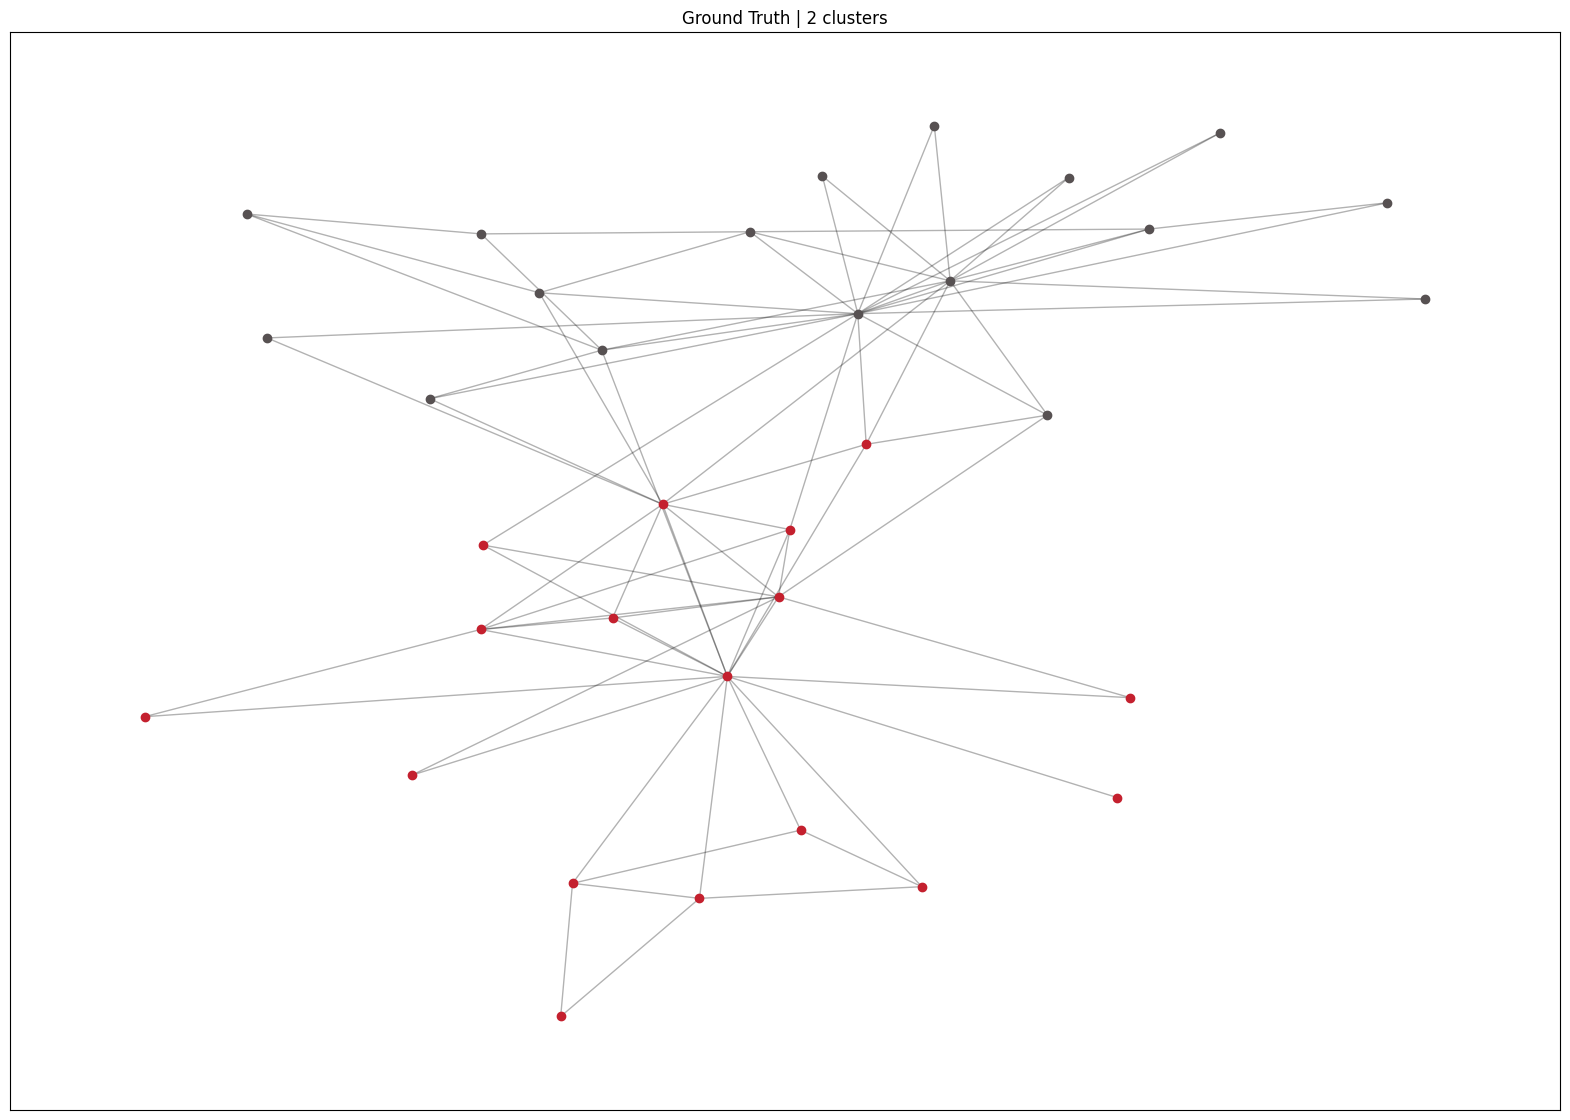

In [3]:
seed(0xAB0BA)

G = nx.karate_club_graph()

pos = nx.spring_layout(G)
club_to_id = {
    'Mr. Hi' : 0,
    'Officer': 1
}

ground_truth = {}
for node, d in G.nodes(data=True):
    ground_truth[node] = club_to_id[d['club']] 

communities = {}
for node, label in ground_truth.items():
    if label in communities:
        communities[label].append(node)
    else:
        communities[label] = [node]
ground_truth_partition = [c for _, c in communities.items()]

plot_communities(ground_truth_partition, pos, algo_name='Ground Truth')

## Louvain

Modularity: 0.42662
AMI: 0.57257 | interval: [0, 1]
ARI: 0.49053 | interval: [-0.5, 1]


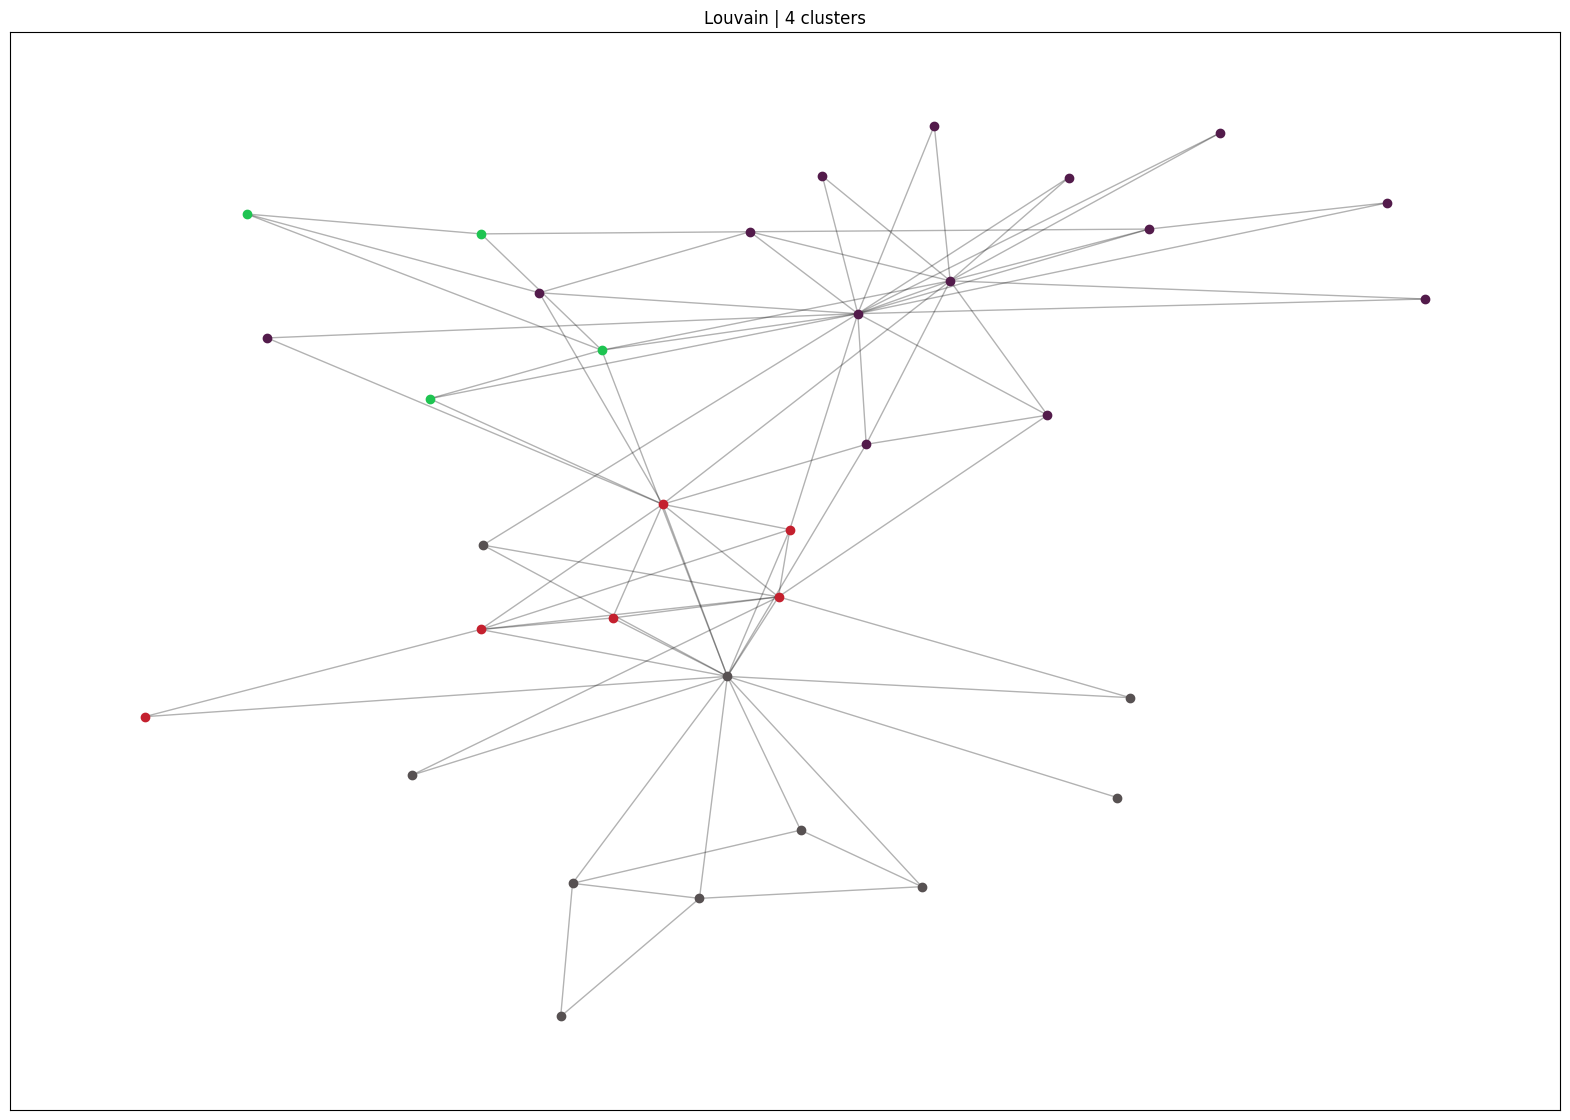

In [4]:
seed(0xAB0BA)

# Run Louvain with default parameters
louvain_partition = louvain_communities(G, seed=42, weight='weight')
print(f'Modularity: {modularity(G, louvain_partition):.5f}')

# Convert Louvain output to node: community_id format
louvain_labels = {}
for i, comm in enumerate(louvain_partition):
    for node in comm:
        louvain_labels[node] = i

compute_metrics(G, ground_truth, louvain_labels)

plot_communities(louvain_partition, pos, algo_name='Louvain')

## Leiden

Modularity: 0.44490
AMI: 0.56667 | interval: [0, 1]
ARI: 0.46459 | interval: [-0.5, 1]


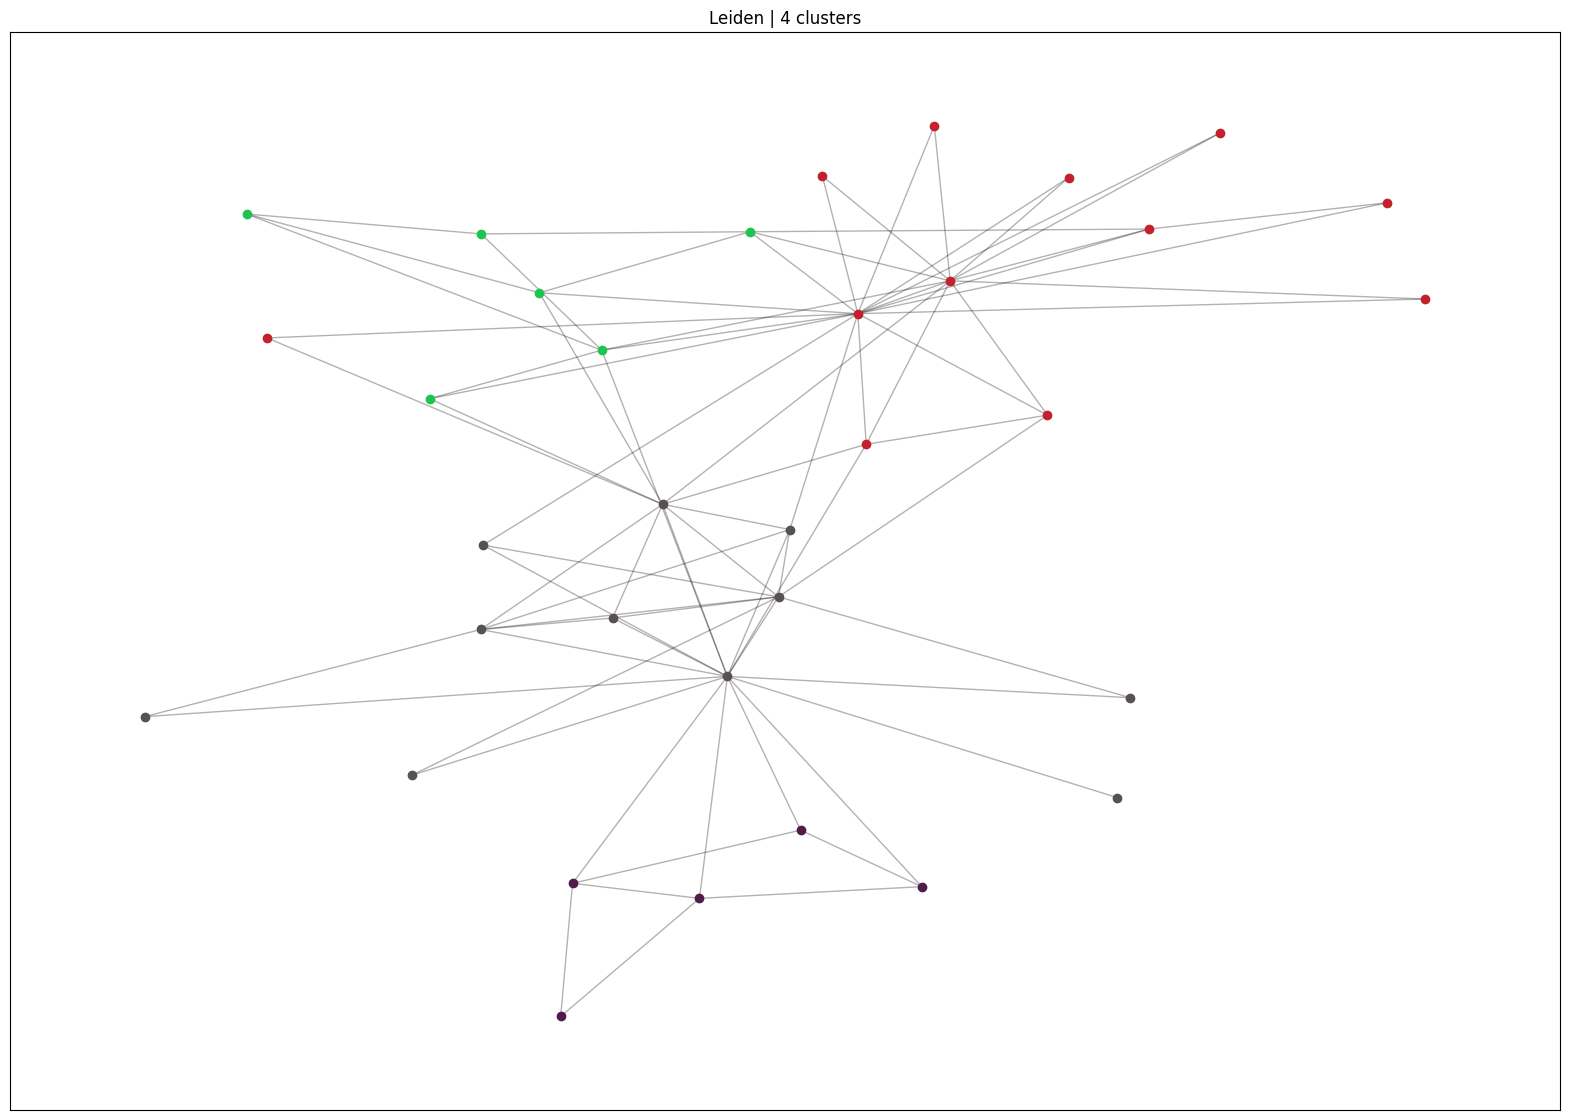

In [5]:
seed(0xAB0BA)

communities = leiden(G, partition_type=la.ModularityVertexPartition, seed=0xAB0BA, weights='weight')

print(f'Modularity: {modularity(G, communities):.5f}')

# Convert Louvain output to node: community_id format
leiden_labels = {}
for i, comm in enumerate(communities):
    for node in comm:
        leiden_labels[node] = i

compute_metrics(G, ground_truth, leiden_labels)

plot_communities(communities, pos, algo_name='Leiden')

## Filtration

Performing Filtration Clustering


100%|██████████| 100/100 [00:00<00:00, 151.45it/s]


Finding best clustering


100%|██████████| 9/9 [00:00<00:00, 7992.53it/s]


Best threshold 0.0183 with score: 0.2618817072839542
Modularity: 0.38117
AMI: 0.56591 | interval: [0, 1]
ARI: 0.66818 | interval: [-0.5, 1]


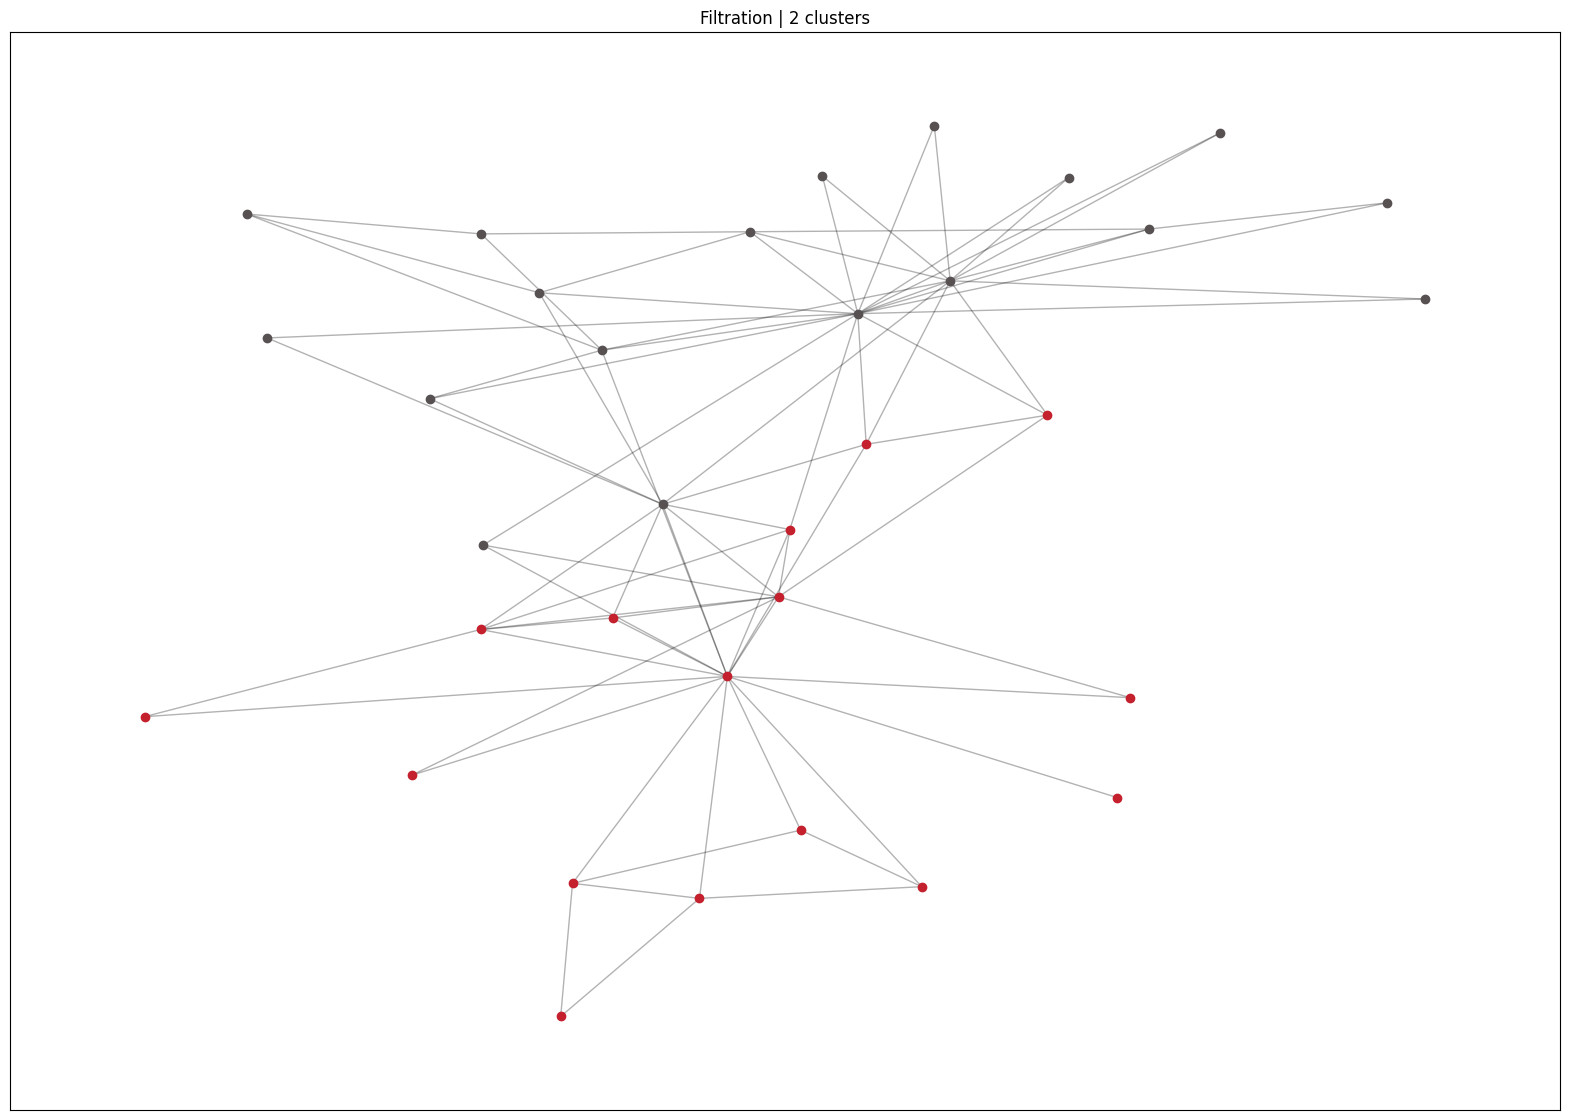

In [6]:
np.random.seed(0xAB0BA)
seed(0xAB0BA)

for a, b, d in G.edges(data=True):
    G[a][b]['weight'] = np.exp(-G[a][b]['weight'])

fc = FiltrationClustering(G, weight='weight')
communities = fc.cluster(n_jobs=N_JOBS)

print(f'Modularity: {modularity(G, communities):.5f}')

# Convert Louvain output to node: community_id format
clustering_labels = {}
for i, comm in enumerate(communities):
    for node in comm:
        clustering_labels[node] = i

compute_metrics(G, ground_truth, clustering_labels)

plot_communities(communities, pos, algo_name='Filtration')

# SNAP: Emails

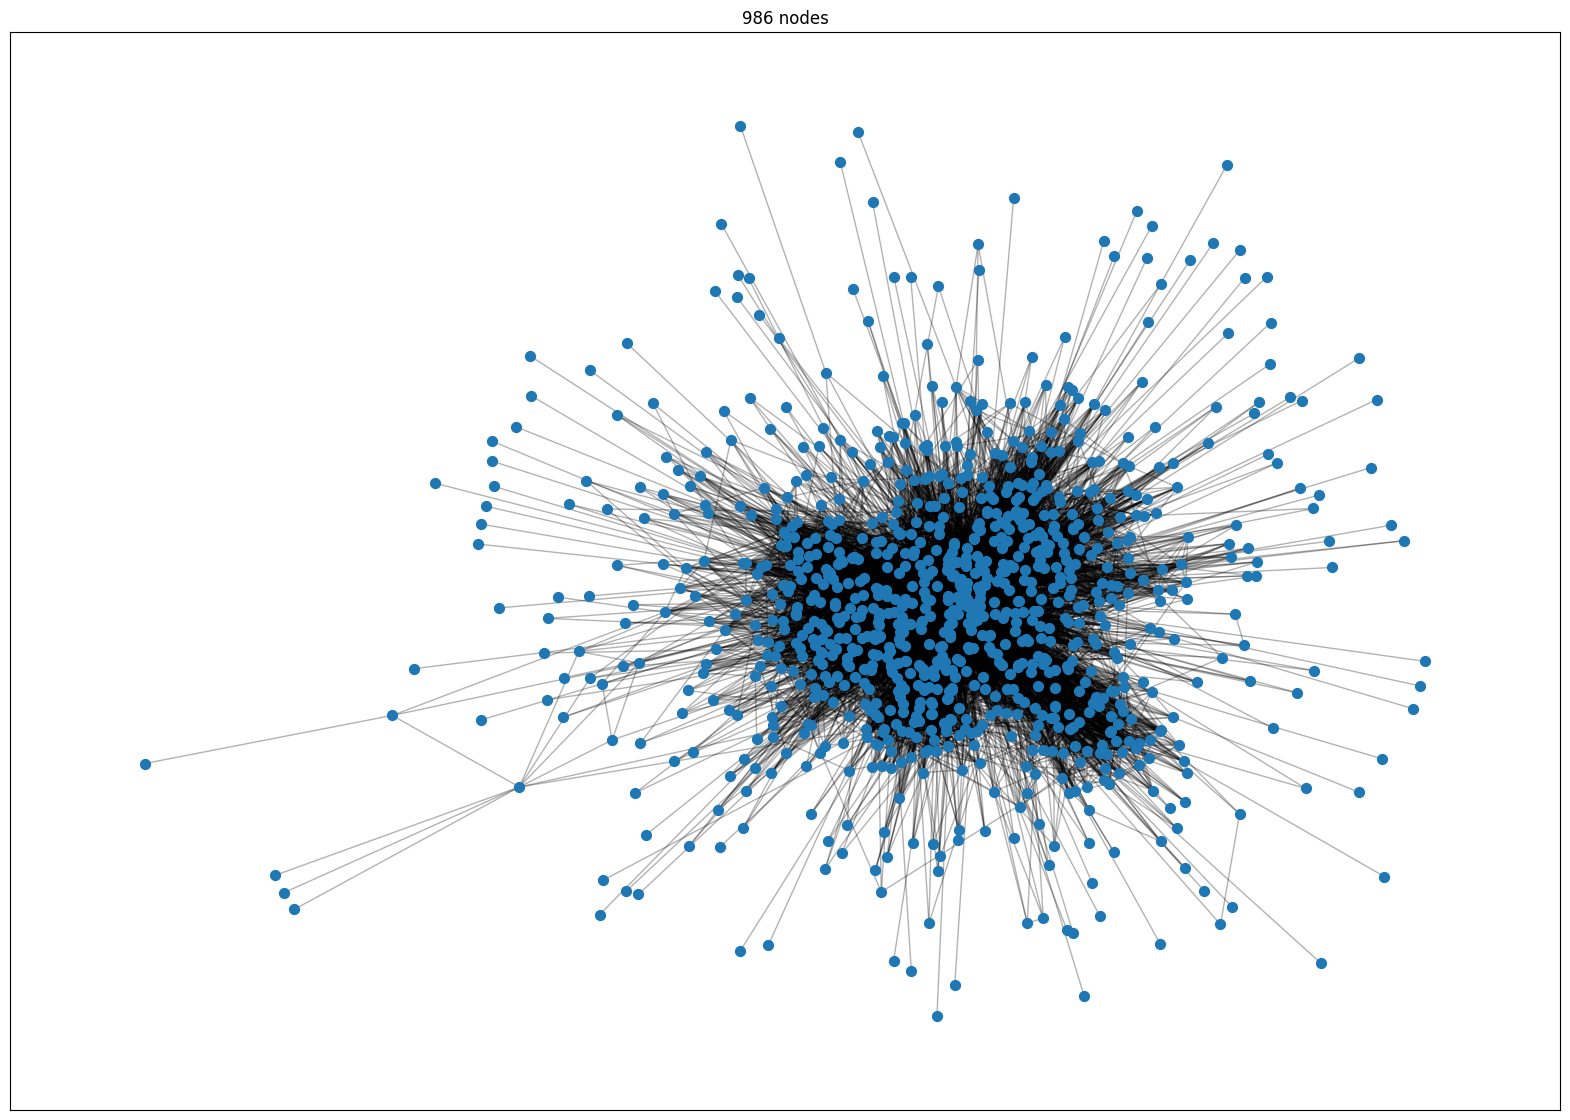

In [7]:
# Load graph (edges)
G = nx.read_edgelist("./data/email-Eu-core.txt", nodetype=int)
G.remove_edges_from(nx.selfloop_edges(G))

# Leave only main component
nodes_subset = list(nx.connected_components(G))[0]
G = G.subgraph(nodes_subset)

# Load ground-truth communities (node: community_id)
ground_truth = {}
with open("./data/email-Eu-core-department-labels.txt") as f:
    for line in f:
        node, label = map(int, line.strip().split())
        if node in nodes_subset:
            ground_truth[node] = label

# Convert ground truth to partition format (list of sets)
ground_truth_partition = {}
for node, comm in ground_truth.items():
    ground_truth_partition.setdefault(comm, set()).add(node)
ground_truth_partition = list(ground_truth_partition.values())

pos = nx.spring_layout(G)

plot_graph(G, pos)

## Louvain

Modularity: 0.41112
AMI: 0.56665 | interval: [0, 1]
ARI: 0.35809 | interval: [-0.5, 1]


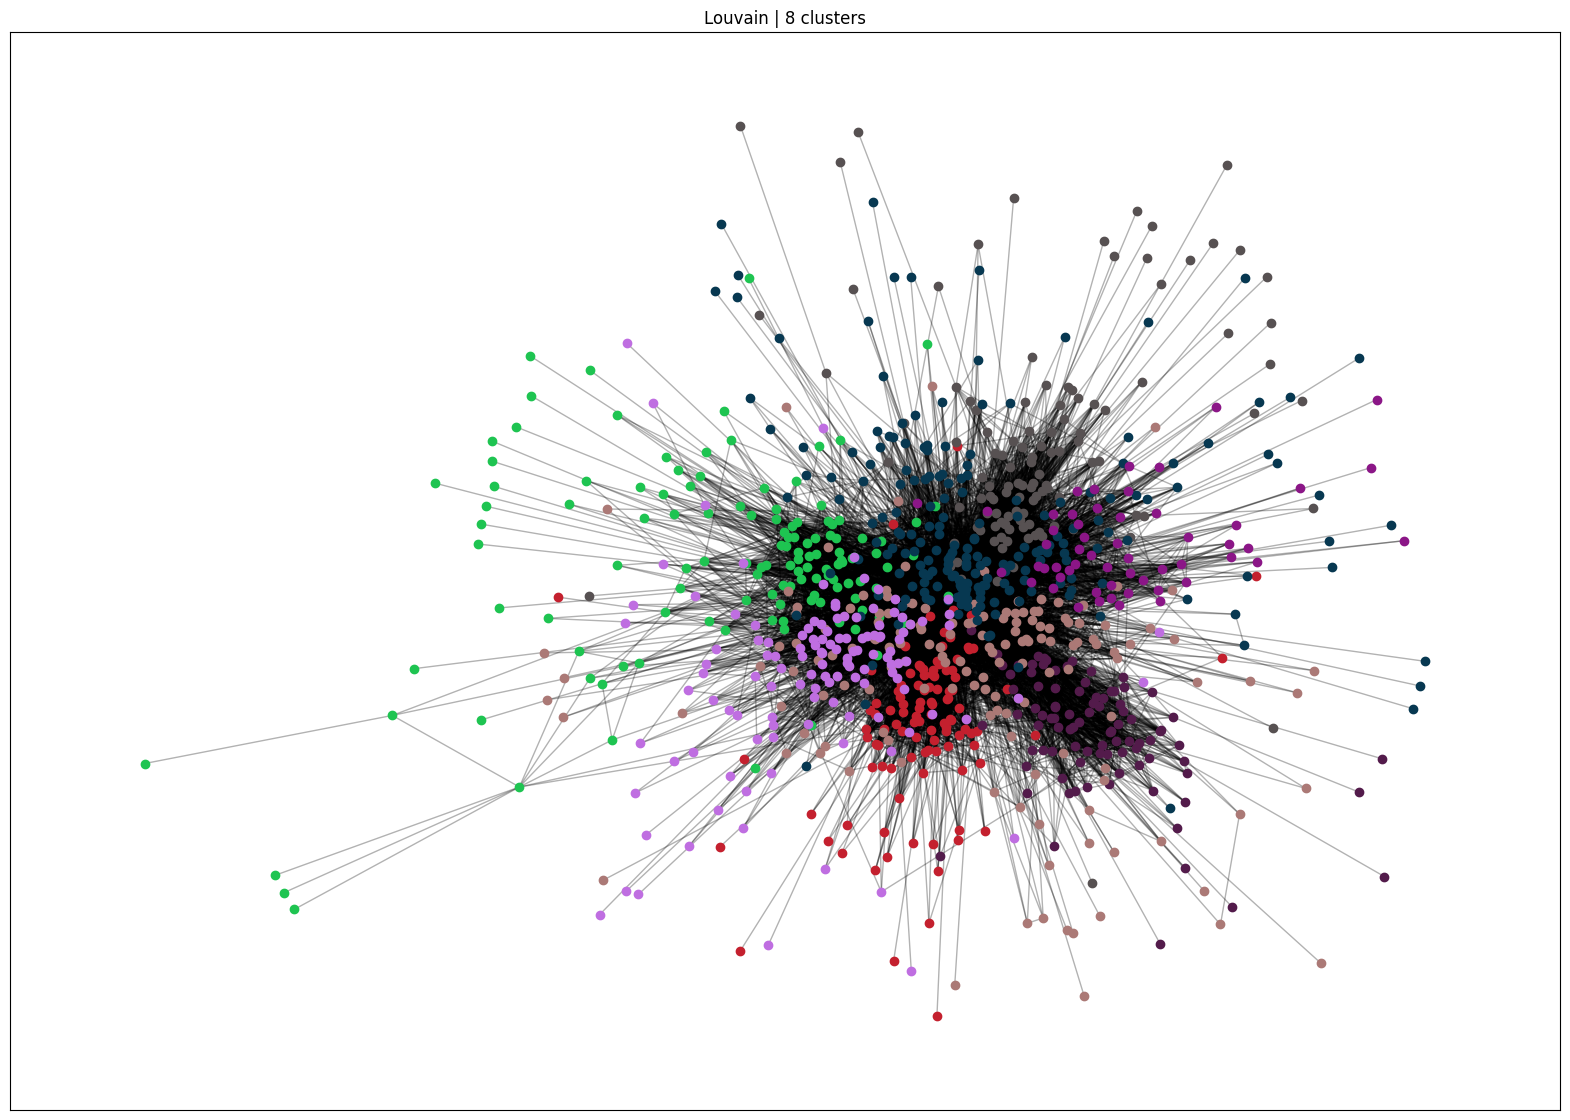

In [8]:
seed(0xAB0BA)

# Run Louvain with default parameters
louvain_partition = louvain_communities(G, seed=42)
print(f'Modularity: {modularity(G, louvain_partition):.5f}')

# Convert Louvain output to node: community_id format
louvain_labels = {}
for i, comm in enumerate(louvain_partition):
    for node in comm:
        louvain_labels[node] = i

compute_metrics(G, ground_truth, louvain_labels)

plot_communities(louvain_partition, pos, algo_name='Louvain')

## Leiden

Modularity: 0.41745
AMI: 0.56902 | interval: [0, 1]
ARI: 0.34366 | interval: [-0.5, 1]


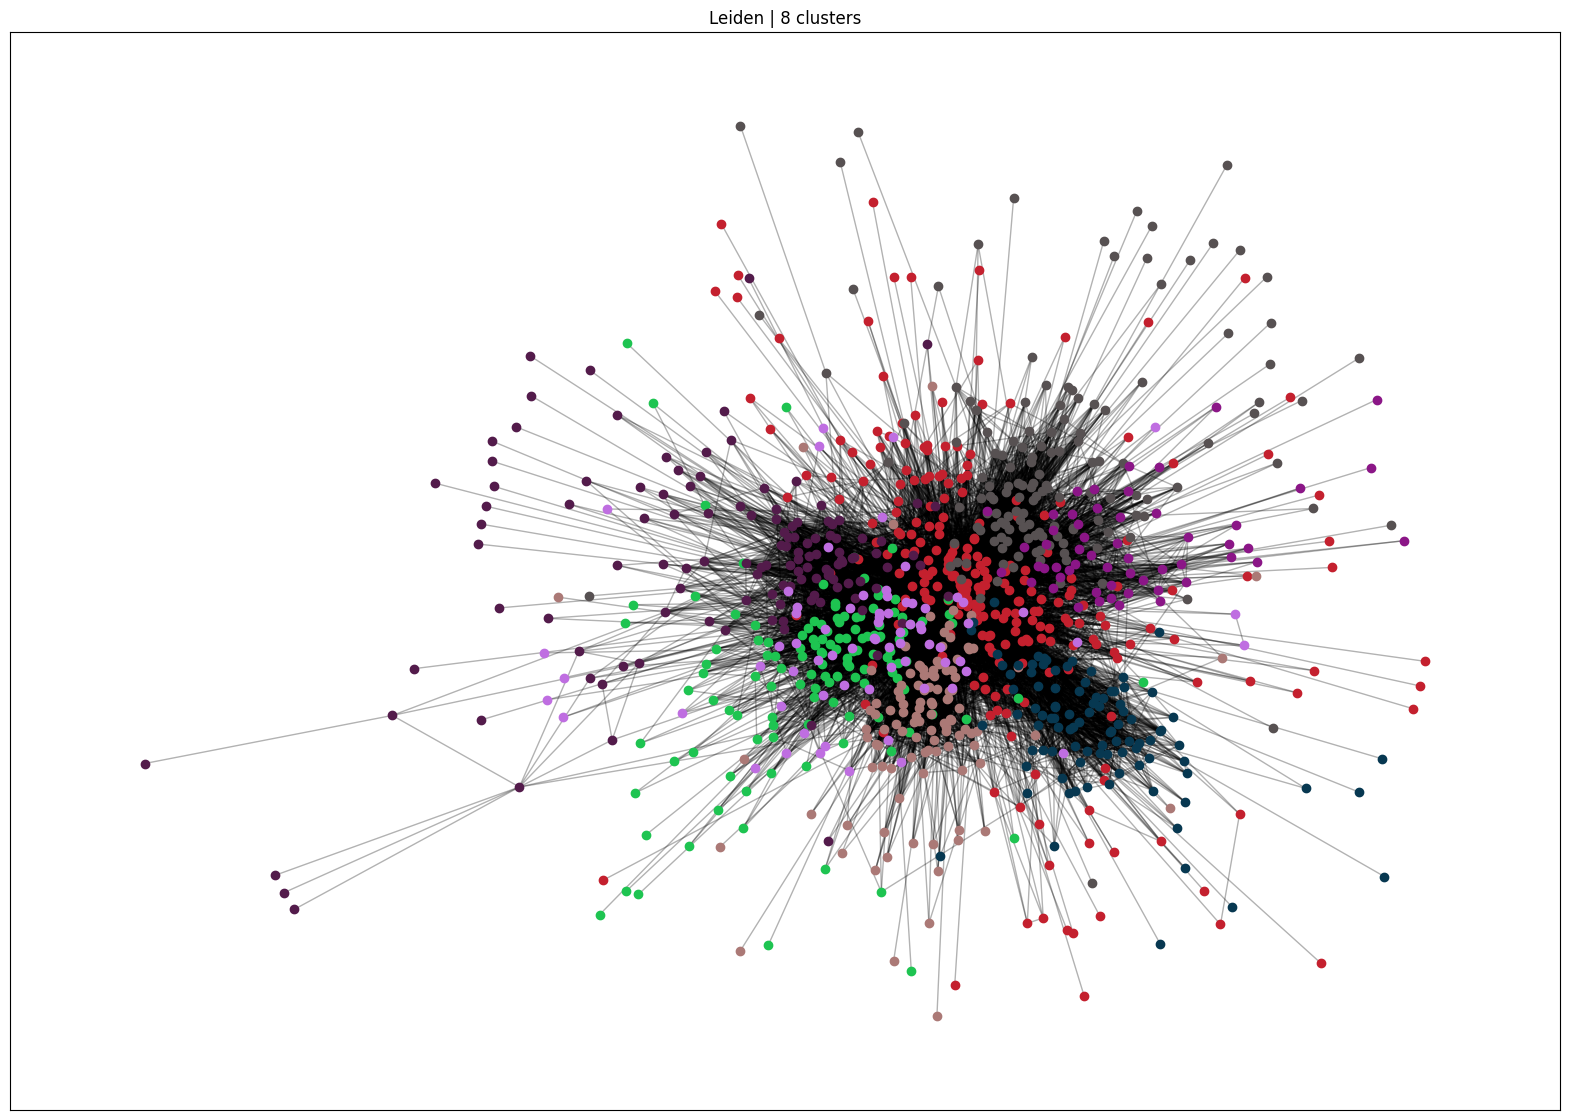

In [9]:
seed(0xAB0BA)

communities = leiden(G, partition_type=la.ModularityVertexPartition, seed=0xAB0BA)

print(f'Modularity: {modularity(G, communities):.5f}')

# Convert Louvain output to node: community_id format
leiden_labels = {}
for i, comm in enumerate(communities):
    for node in comm:
        leiden_labels[node] = i

compute_metrics(G, ground_truth, leiden_labels)

plot_communities(communities, pos, algo_name='Leiden')

## Filtration
Because graphs here may not have weights, we will use graph curvature instead.


### Olivier Ricci curvature

In [ ]:
# Compute OllivierRicci curvature
orc = OllivierRicci(G, alpha=0.5, verbose="INFO")
orc.compute_ricci_curvature()
G_orc = orc.G

curvature_distribution = [d['ricciCurvature'] for a,b,d in G_orc.edges(data=True)]
mean = np.mean(curvature_distribution)
std = np.std(curvature_distribution)

# Transform curvature into new metric, so that it is minimal in dense regions
for a, b in G_orc.edges:
    # Normalize
    curv = (G_orc[a][b]['ricciCurvature'] - mean) / std
    G_orc[a][b]['curvature_transformed'] = np.exp(-curv)

Performing Filtration Clustering


100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Finding best clustering


100%|██████████| 100/100 [00:00<00:00, 111.51it/s]


Best threshold 0.3051 with score: 0.0915113892416549
Modularity: 0.31704
AMI: 0.56454 | interval: [0, 1]
ARI: 0.33782 | interval: [-0.5, 1]


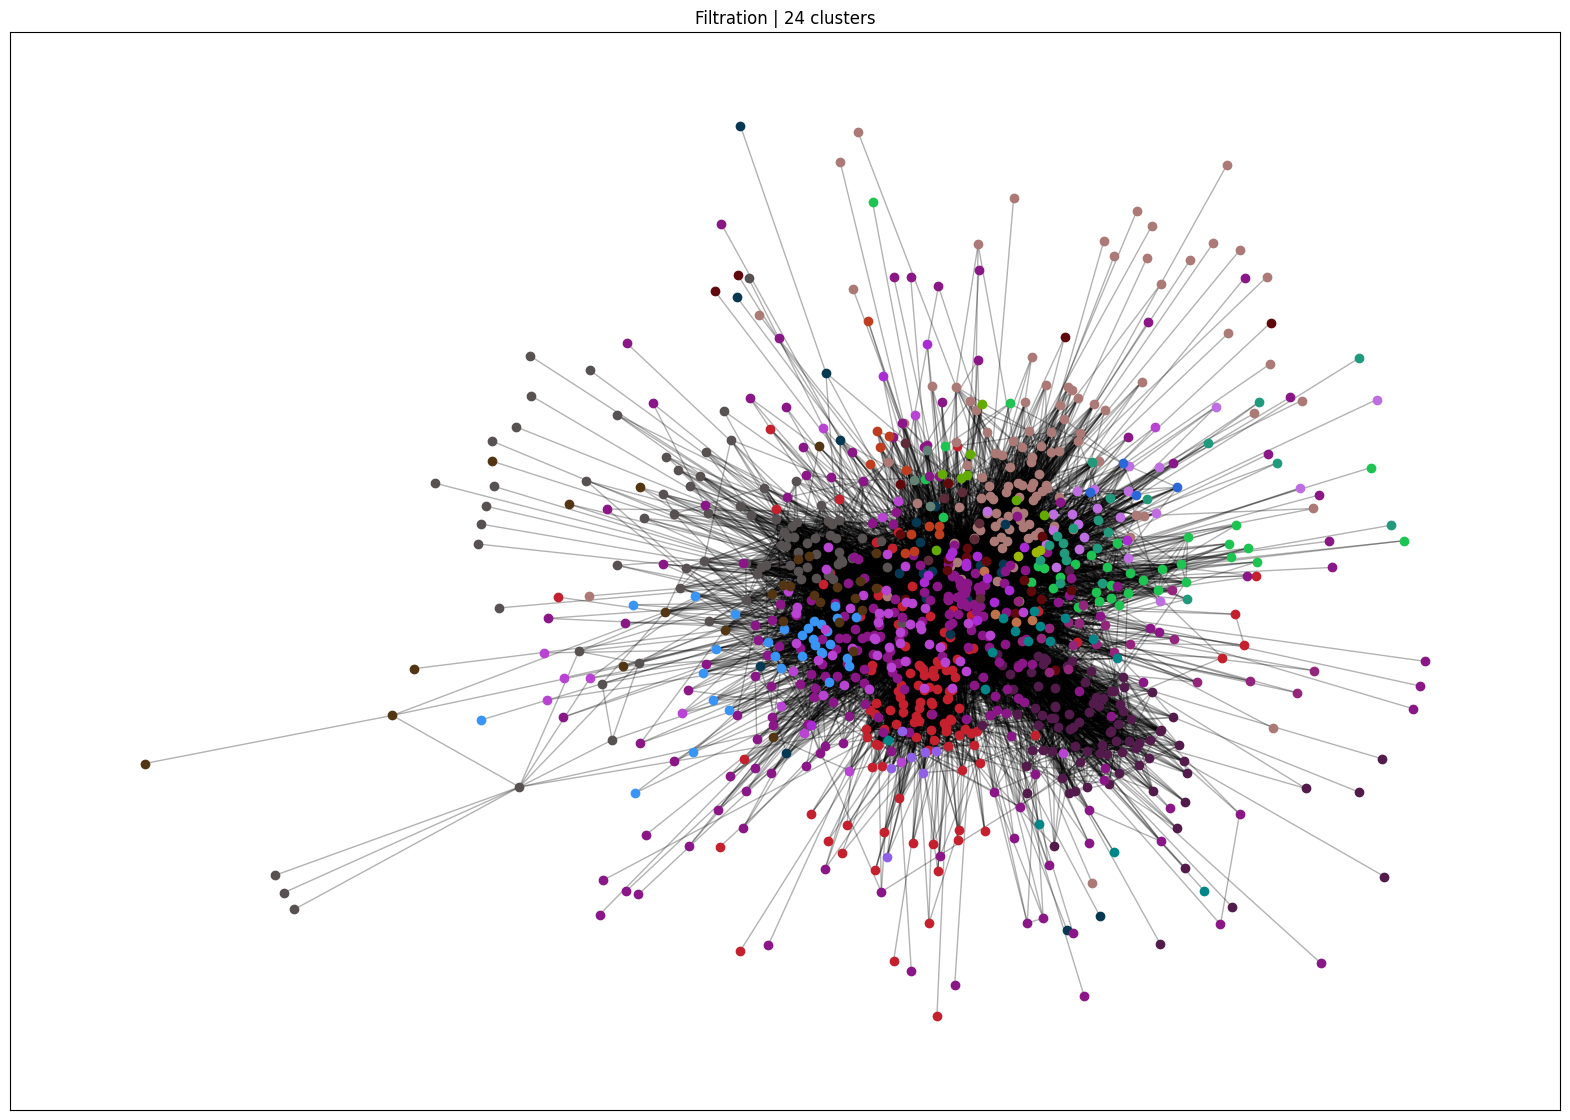

In [11]:
np.random.seed(0xAB0BA)
seed(0xAB0BA)

fc = FiltrationClustering(G_orc, weight='curvature_transformed')
communities = fc.cluster(n_jobs=N_JOBS)

print(f'Modularity: {modularity(G, communities):.5f}')

# Convert output to node: community_id format
clustering_labels = {}
for i, comm in enumerate(communities):
    for node in comm:
        clustering_labels[node] = i

compute_metrics(G, ground_truth, clustering_labels)

plot_communities(communities, pos, algo_name='Filtration')

### Forman Ricci

In [14]:
# Compute FormanRicci curvature
frc = FormanRicci(G)
frc.compute_ricci_curvature()
G_frc = frc.G

curvature_distribution = [d['formanCurvature'] for a,b,d in G_frc.edges(data=True)]
mean = np.mean(curvature_distribution)
std = np.std(curvature_distribution)

# Transform curvature into new metric, so that it is minimal in dense regions
for a, b in G_frc.edges:
    # Normalize
    curv = (G_frc[a][b]['formanCurvature'] - mean) / std
    G_frc[a][b]['curvature_transformed'] = np.exp(-curv)

Performing Filtration Clustering


100%|██████████| 100/100 [02:32<00:00,  1.53s/it]


Finding best clustering


100%|██████████| 100/100 [00:00<00:00, 107.22it/s]


Best threshold 0.6126 with score: 0.019879306841252144
Modularity: 0.10399
AMI: 0.14753 | interval: [0, 1]
ARI: 0.01873 | interval: [-0.5, 1]


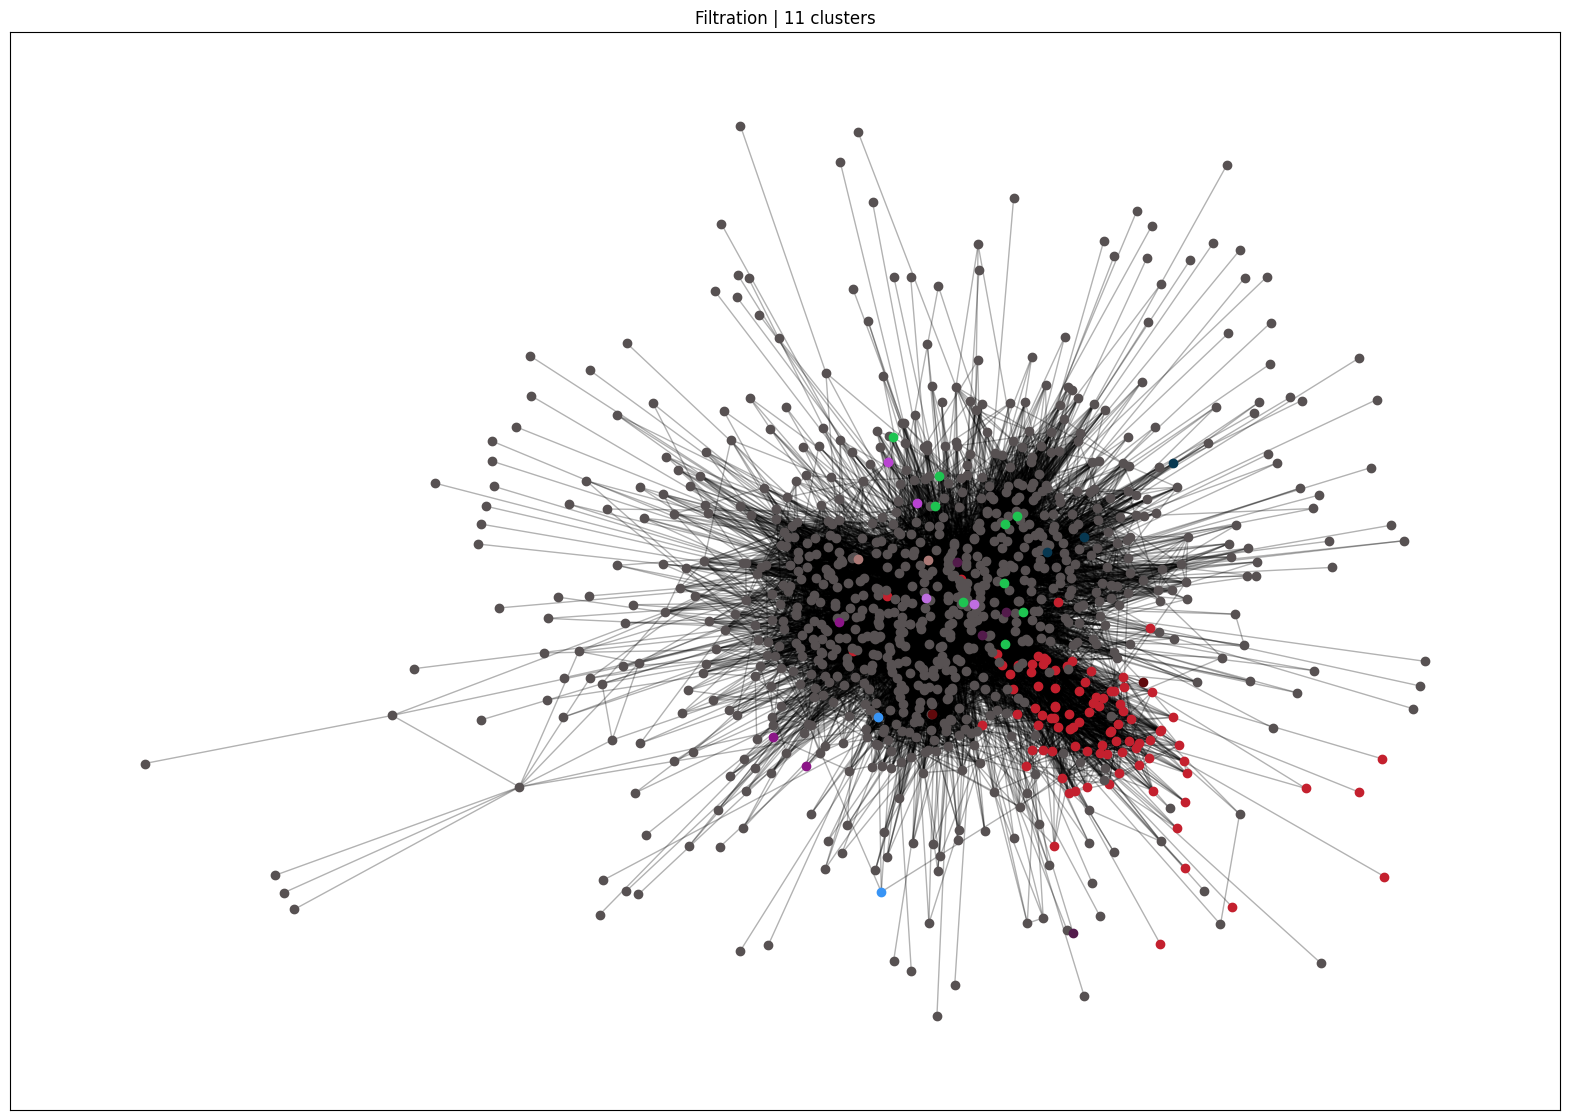

In [15]:
np.random.seed(0xAB0BA)
seed(0xAB0BA)

fc = FiltrationClustering(G_frc, weight='curvature_transformed')
communities = fc.cluster(n_jobs=N_JOBS)

print(f'Modularity: {modularity(G, communities):.5f}')

# Convert Louvain output to node: community_id format
clustering_labels = {}
for i, comm in enumerate(communities):
    for node in comm:
        clustering_labels[node] = i

compute_metrics(G, ground_truth, clustering_labels)

plot_communities(communities, pos, algo_name='Filtration')

### Resistance metric

In [19]:
resistance_dist = nx.resistance_distance(G)

for a, b in G.edges:
    # Normalize
    G[a][b]['resistance'] = resistance_dist[a][b]

Performing Filtration Clustering


100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Finding best clustering


100%|██████████| 100/100 [00:00<00:00, 128.36it/s]


Best threshold 0.2988 with score: 0.0005812880537319231
Modularity: 0.00112
AMI: 0.00079 | interval: [0, 1]
ARI: -0.00180 | interval: [-0.5, 1]


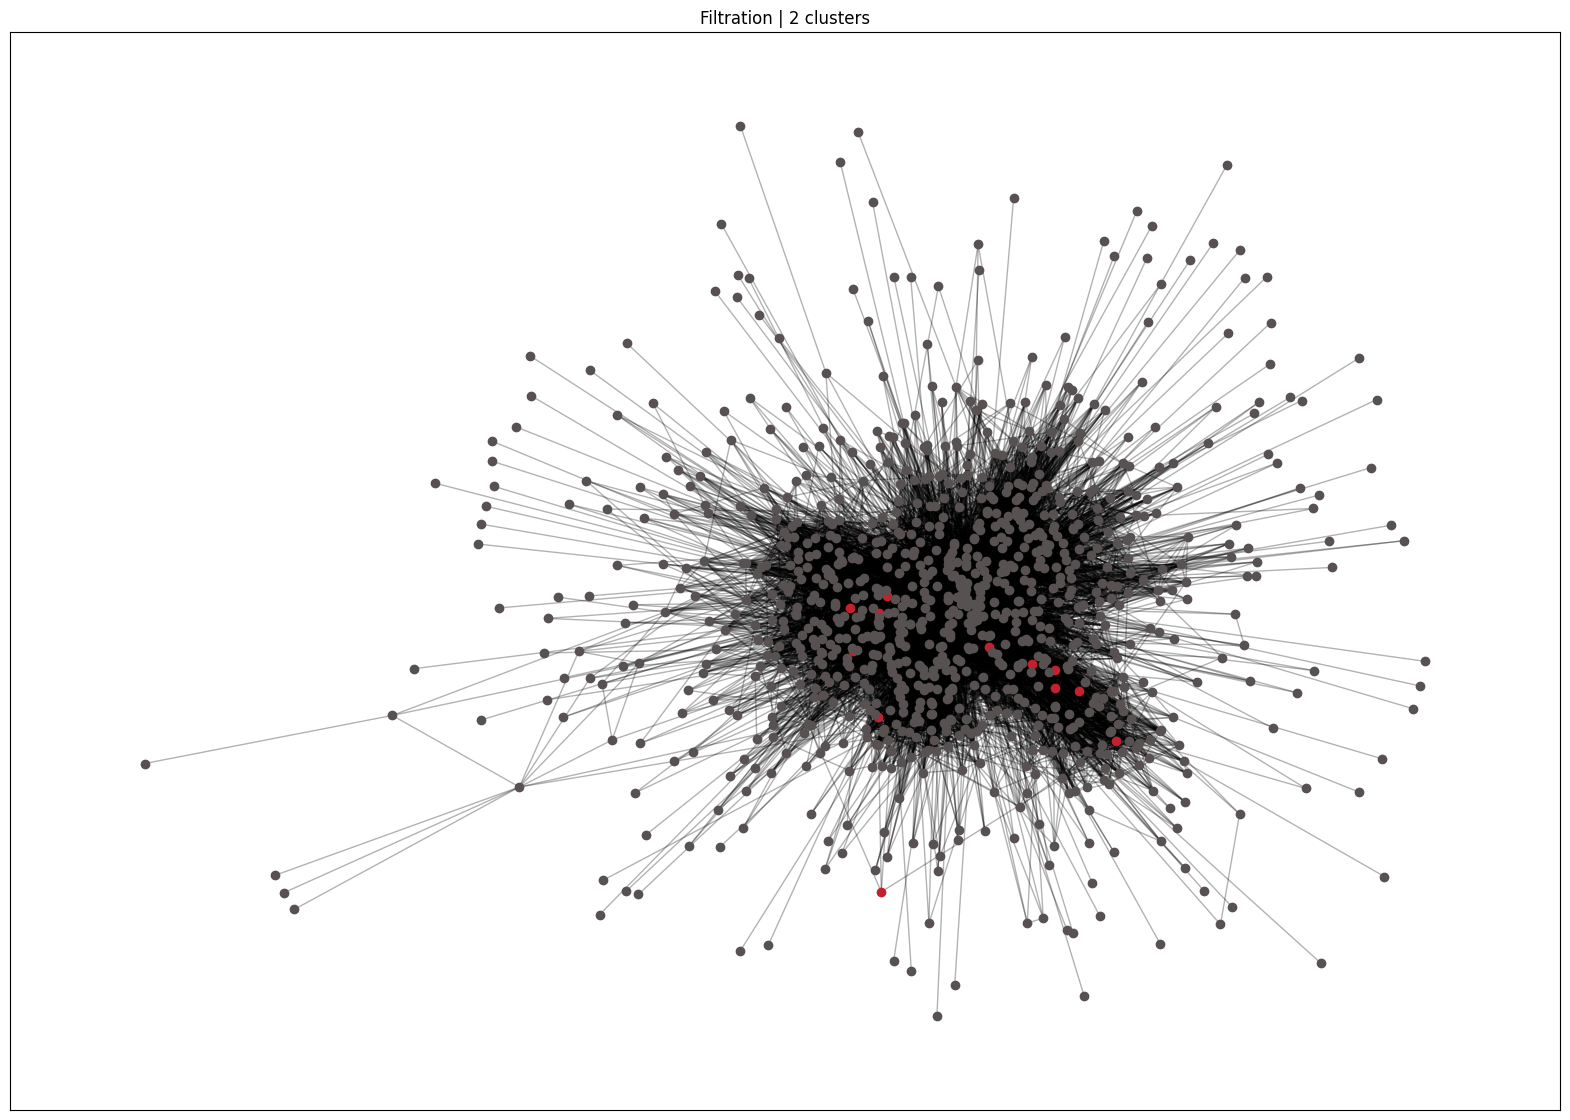

In [20]:
np.random.seed(0xAB0BA)
seed(0xAB0BA)

fc = FiltrationClustering(G, weight='resistance')
communities = fc.cluster(n_jobs=N_JOBS)

print(f'Modularity: {modularity(G, communities):.5f}')

# Convert Louvain output to node: community_id format
clustering_labels = {}
for i, comm in enumerate(communities):
    for node in comm:
        clustering_labels[node] = i

compute_metrics(G, ground_truth, clustering_labels)

plot_communities(communities, pos, algo_name='Filtration')